<div align="right">
  <font size="1">Albert Montenegro - Introducción a Redes Neuronales Artificiales - Universidad Central</font>
</div>

In [1]:
import os
# Deshabilita la GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

# Suprime los logs de TensorFlow relacionados con errores e información
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  

# Suprime las advertencias para una salida más limpia
import warnings
warnings.filterwarnings('ignore')

# Importa TensorFlow y Keras
import tensorflow as tf
import keras

# Imprime las versiones de TensorFlow y Keras instaladas en el entorno
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

E0000 00:00:1732230789.647540  121478 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732230789.652535  121478 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Keras version: 3.6.0


In [2]:
# Importación de módulos estándar
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importación de módulos de Keras para construcción de modelos de redes neuronales
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input,  Conv1D
from keras import regularizers
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras import metrics

# Importación de módulos de scikit-learn para preprocesamiento y evaluación de modelos
from sklearn.model_selection import KFold, train_test_split, cross_validate, cross_val_score
from sklearn.metrics import (mean_squared_error, recall_score, precision_score, 
                             accuracy_score, f1_score, confusion_matrix, precision_recall_curve)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Importación del módulo time para medir tiempos de ejecución
from time import time

# Configuración de semillas aleatorias para reproducibilidad
np.random.seed(7)
seed = 15
rng = np.random.RandomState(313)

# Configuración para visualizar gráficos en línea en Jupyter Notebook
%matplotlib inline



## Carga y Exploración de los Datos

En esta sección, cargamos los conjuntos de datos balanceados para entrenamiento y prueba, exploramos su composición y preparamos las características (`X`) y las etiquetas (`Y`) para el modelado.

#### Propósito
- Leer los datos desde archivos CSV.
- Verificar la distribución de clases en los conjuntos de datos balanceados.
- Separar las características (`X`) de las etiquetas (`Y`) para ambos conjuntos.

#### Resultados Observados

1. **Conjunto de Entrenamiento**:
   - Cantidad de observaciones por clase:
     - Clase `0` (sanos): 6,212 (50.06%)
     - Clase `1` (afectados): 6,196 (49.94%)
   - Dimensiones:
     - Características: (12,408 observaciones, 606 columnas)
     - Etiquetas: (12,408 observaciones)

2. **Conjunto de Prueba 1**:
   - Cantidad de observaciones por clase:
     - Clase `0` (sanos): 777 (50.10%)
     - Clase `1` (afectados): 774 (49.90%)
   - Dimensiones:
     - Características: (1,551 observaciones, 606 columnas)
     - Etiquetas: (1,551 observaciones)

#### Comentario
Este análisis inicial confirma que los conjuntos de datos están balanceados entre las clases y listos para el modelado. Las etiquetas (`CLASS_LABEL`) se manejan de forma separada para entrenar y evaluar modelos de clasificación binaria.


In [3]:
X_train = pd.read_csv(r"../Datos/BinarioTrainBalanced.csv")
X_test  = pd.read_csv(r"../Datos/BinarioTest1Balanced.csv")

In [4]:
print("\n\t\tDatos de entrenamiento")
nr_clases = X_train['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_train.shape[0])
Y_train = X_train['CLASS_LABEL']
X_train = X_train.drop(['CLASS_LABEL'], axis=1)
print(X_train.shape, Y_train.shape)

print("\n\t\tDatos de prueba")
nr_clases = X_test['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_test.shape[0])
Y_test = X_test['CLASS_LABEL']
X_test = X_test.drop(['CLASS_LABEL'], axis=1)
print(X_test.shape, Y_test.shape)


		Datos de entrenamiento

Cantidad  CLASS_LABEL
0    6212
1    6196
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
0    50.064475
1    49.935525
Name: count, dtype: float64
(12408, 606) (12408,)

		Datos de prueba

Cantidad  CLASS_LABEL
0    777
1    774
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
0    50.096712
1    49.903288
Name: count, dtype: float64
(1551, 606) (1551,)


## Cambio de tamaño de los datos
El cambio de tamaño del conjunto de datos `X_train` y `X_test` a través de `reshape` es necesario debido al uso de una red neuronal convolucional 1D (`Conv1D`) en este modelo. Las redes convolucionales 1D requieren que los datos de entrada tengan una forma específica para procesar correctamente las características:

1. **Forma original de los datos**:
   - `X_train` y `X_test` se cargan inicialmente como DataFrames o matrices 2D de forma `(n_samples, n_features)`, donde:
     - `n_samples` es el número de muestras.
     - `n_features` es el número de características por muestra.

2. **Requerimiento de las capas `Conv1D`**:
   - Las capas convolucionales 1D esperan que los datos de entrada tengan una forma tridimensional de `(n_samples, time_steps, n_channels)`, donde:
     - `time_steps` corresponde al número de características o pasos temporales de cada muestra.
     - `n_channels` es el número de canales (generalmente 1 para datos univariantes).

3. **Transformación realizada**:
   ```python
   X_train = X_train.to_numpy().reshape((X_train.shape[0], X_train.shape[1], 1))
   X_test = X_test.to_numpy().reshape((X_test.shape[0], X_test.shape[1], 1))


### Justificación práctica

#### Compatibilidad
Sin esta transformación, el modelo arrojaría un error, ya que la capa `Conv1D` no puede procesar entradas de dimensión 2D (`(n_samples, n_features)`).

#### Flexibilidad
La forma `(n_samples, time_steps, n_channels)` también permite incorporar más canales en el futuro si se añaden características adicionales o representaciones multivariantes.



In [5]:
X_train = X_train.to_numpy().reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.to_numpy().reshape((X_test.shape[0], X_test.shape[1], 1))
X_train.shape

(12408, 606, 1)

## Crear CNN 1D y Búsqueda de Hiperparámetros con Keras Tuner

En esta sección, se define una red neuronal convolucional 1D utilizando Keras y se emplea la biblioteca Keras Tuner para buscar automáticamente los hiperparámetros óptimos del modelo.

#### Propósito
- Construir una red neuronal convolucional adaptativa con capas `Conv1D`.
- Optimizar hiperparámetros como el número de filtros, el tamaño del kernel, la tasa de aprendizaje y la estructura de las capas densas.
- Utilizar el algoritmo `HyperBand` para realizar una búsqueda eficiente de los hiperparámetros.


#### Pasos del Código

1. **Definición del Modelo**:
   - El modelo se define dentro de la función `build_model(hp)`, la cual utiliza el módulo Keras Tuner para recibir y ajustar hiperparámetros.
   - Arquitectura de la red:
     - Entrada con forma `(606, 1)`, adaptada a las capas `Conv1D`.
     - Tres capas convolucionales 1D (`Conv1D`) con hiperparámetros ajustables:
       - `conv_1_filter`: Número de filtros (4 o 8).
       - `conv_1_kernel`: Tamaño del kernel (3 o 5).
       - `conv_2_filter` y `conv_3_filter`: Número de filtros (entre 8 y 16, con pasos de 8).
       - `conv_2_kernel` y `conv_3_kernel`: Tamaño del kernel (3 o 5).
     - Una capa de aplanamiento (`Flatten`) para preparar los datos para las capas densas.
     - Una capa densa (`Dense`) con número de neuronas ajustable:
       - `dense_units1`: Entre 10 y 50, con pasos de 16.
     - Una capa de salida con una única neurona y activación sigmoide para clasificación binaria.
   - Tasa de aprendizaje (`learning_rate`) definida como un hiperparámetro con valores posibles:
     - 0.1, 0.01 o 0.001.

2. **Compilación del Modelo**:
   - Optimizador: Adam con tasa de aprendizaje seleccionada.
   - Función de pérdida: `binary_crossentropy` para problemas de clasificación binaria.
   - Métricas:
     - Precisión binaria (`BinaryAccuracy`).
     - Sensibilidad (`Recall`).
     - Precisión (`Precision`).
     - Área bajo la curva (`AUC`).

3. **Búsqueda de Hiperparámetros**:
   - Se utiliza el algoritmo `HyperBand`:
     - Permite realizar una búsqueda eficiente asignando más recursos a configuraciones prometedoras.
     - Busca maximizar la precisión binaria (`binary_accuracy`).
     - Configuración:
       - `max_epochs=100`: Máximo de 100 épocas por modelo.
       - Directorio de trabajo: `keras_tuner_cnn1d`.
       - Proyecto: `keras_tuner_cnn1d`.
   - Se ejecuta el método `tuner.search`:
     - Entrena el modelo en el conjunto de datos de entrenamiento (`X_train`, `Y_train`).
     - Reserva el 30% de los datos de entrenamiento para validación.


#### Resultados Esperados
- **Modelo óptimo**: El mejor conjunto de hiperparámetros seleccionado para maximizar la precisión binaria en el conjunto de validación.
- **Arquitectura ajustada**:
  - Filtros y tamaños de kernel óptimos en las capas convolucionales.
  - Número adecuado de neuronas en la capa densa.
  - Tasa de aprendizaje óptima.
- **Métricas de evaluación**: Precisión, sensibilidad, precisión y AUC en el modelo óptimo.


#### Comentario
Este enfoque permite optimizar automáticamente tanto la arquitectura de la red neuronal como los parámetros de entrenamiento. La combinación de capas convolucionales y densas ofrece una gran flexibilidad para modelar patrones complejos en los datos. La búsqueda de hiperparámetros mejora significativamente el rendimiento al encontrar configuraciones óptimas de manera sistemática.


In [6]:
import kerastuner as kt
def build_model(hp):
    time_steps = 5
    model = Sequential()
    
    model.add(Input(shape=(606,1)))
                 
    model.add(Conv1D(
      filters=hp.Choice('conv_1_filter', values = [4,8]),
      kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
      activation='relu'))
   
    model.add(Conv1D(
        filters=hp.Int('conv_2_filter', min_value=8, max_value=16, step=8),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'))  
    
    model.add(Conv1D(
        filters=hp.Int('conv_3_filter', min_value=8, max_value=16, step=8),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation='relu'))  
              
    model.add(Flatten())  

    hp_units1 = hp.Int('dense_units1', min_value=10, max_value=50, step=16)
    model.add(Dense(units=hp_units1, activation='relu'))
 
    model.add(Dense(1, activation='sigmoid'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])

    model.compile(
      optimizer=Adam(learning_rate=hp_learning_rate),
      loss='binary_crossentropy',
      metrics=[metrics.BinaryAccuracy(),
               metrics.Recall(),
               metrics.Precision(),
               metrics.AUC()]
    )
    return model

In [7]:
# HyperBand algorithm from keras tuner
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("binary_accuracy", direction="max"),
    max_epochs=100,
    directory='keras_tuner_cnn1d',
    project_name='keras_tuner_cnn1d'
)

Reloading Tuner from keras_tuner_cnn1d/keras_tuner_cnn1d/tuner0.json


In [8]:
tuner.search(X_train, Y_train, epochs=100, batch_size=128, validation_split=0.3)

### Resultados de la Búsqueda de Hiperparámetros y Modelo Óptimo

En esta sección, se presentan los resultados obtenidos tras la búsqueda de hiperparámetros utilizando Keras Tuner y un resumen de la arquitectura del mejor modelo seleccionado.

---

#### Resultados de la Búsqueda
- **Duración Total**: 54 minutos y 31 segundos.
- **Mejor Exactitud Binaria**: `0.9790` (Trial 0146).
- **Número Total de Pruebas**: 254.

Los 10 mejores ensayos y sus hiperparámetros asociados:

| ID | `c_1_filter` | `c_1_kernel` | `c_2_filter` | `c_2_kernel` | `c_3_filter` | `c_3_kernel` | `dense` | `learning_rate` | Exactitud Binaria |
|----------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|----------------|-----------------|-------------------|
| 0146     | 4               | 5               | 16              | 5               | 8               | 5               | 42             | 0.01            | 0.9790            |
| 0251     | 8               | 3               | 16              | 5               | 8               | 3               | 42             | 0.01            | 0.9722            |
| 0234     | 4               | 3               | 8               | 5               | 16              | 5               | 26             | 0.01            | 0.9651            |
| 0208     | 4               | 3               | 16              | 3               | 8               | 3               | 42             | 0.01            | 0.9602            |
| 0147     | 8               | 5               | 8               | 5               | 16              | 3               | 42             | 0.001           | 0.9466            |
| 0245     | 8               | 3               | 8               | 3               | 16              | 3               | 26             | 0.001           | 0.9459            |
| 0209     | 4               | 3               | 8               | 3               | 16              | 5               | 10             | 0.01            | 0.9367            |
| 0246     | 4               | 3               | 16              | 5               | 8               | 3               | 26             | 0.001           | 0.9324            |
| 0249     | 8               | 5               | 16              | 3               | 16              | 3               | 10             | 0.001           | 0.9234            |
| 0235     | 4               | 3               | 8               | 5               | 16              | 5               | 26             | 0.001           | 0.9227            |

---

#### Arquitectura del Mejor Modelo
El mejor modelo seleccionado se encuentra en el Trial 0146. Su arquitectura es la siguiente:

| Capa           | Tipo        | Forma de Salida   | Parámetros | Hiperparámetros                                           |
|----------------|-------------|-------------------|------------|-------------------------------------------------------------------|
| `conv1d_1`     | Conv1D      | (None, 602, 4)    | 24         | `filters`: 4, `kernel`: 5  |
| `conv1d_2`     | Conv1D      | (None, 598, 16)   | 336        | `filters`: 16, `kernel`: 5 |
| `conv1d_3`     | Conv1D      | (None, 594, 8)    | 648        | `filters`: 8, `kernel`: 5  |
| `flatten`      | Flatten     | (None, 4752)      | 0          | -                          |
| `dense`        | Dense       | (None, 42)        | 199,626    | `units`: 42                |
| `salida`       | Dense       | (None, 1)         | 43         | `learning_rate`: 0.01      |


- **Total de Parámetros**: 200,677.
  - Parámetros Entrenables: 200,677.
  - Parámetros No Entrenables: 0.

---

#### Comentarios
1. **Exactitud Alcanzada**:
   - El modelo alcanzó una precisión binaria del 97.90%, indicando un excelente rendimiento en el conjunto de validación.
2. **Configuración del Modelo**:
   - El modelo utiliza tres capas convolucionales con filtros y tamaños de kernel ajustados, seguidas de una capa completamente conectada con 42 neuronas y una salida sigmoide para la clasificación binaria.
3. **Eficiencia del Tuner**:
   - La búsqueda permitió explorar combinaciones de hiperparámetros, maximizando la precisión binaria de manera eficiente.

Este modelo óptimo está preparado para ser evaluado en el conjunto de prueba y para ajustes adicionales si es necesario.


In [9]:
tuner.results_summary()

Results summary
Results in keras_tuner_cnn1d/keras_tuner_cnn1d
Showing 10 best trials
Objective(name="binary_accuracy", direction="max")

Trial 0146 summary
Hyperparameters:
conv_1_filter: 4
conv_1_kernel: 5
conv_2_filter: 16
conv_2_kernel: 5
conv_3_filter: 8
conv_3_kernel: 5
dense_units1: 42
learning_rate: 0.01
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0144
Score: 0.9790443181991577

Trial 0251 summary
Hyperparameters:
conv_1_filter: 8
conv_1_kernel: 3
conv_2_filter: 16
conv_2_kernel: 5
conv_3_filter: 8
conv_3_kernel: 3
dense_units1: 42
learning_rate: 0.01
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9722509980201721

Trial 0234 summary
Hyperparameters:
conv_1_filter: 4
conv_1_kernel: 3
conv_2_filter: 8
conv_2_kernel: 5
conv_3_filter: 16
conv_3_kernel: 5
dense_units1: 26
learning_rate: 0.01
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0228
Score: 0.96511226

In [10]:
best_models = tuner.get_best_models(num_models=10)

In [11]:
best_models[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 602, 4)         │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 598, 16)        │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 594, 8)         │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4752)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 42)             │       199,626 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            43 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,677 (783.89 KB)

 Trainable params: 200,677 (783.89 KB)

 Non-trainable params: 0 (0.00 B)

### Evaluación del Modelo Óptimo

Se evalúa el rendimiento del modelo óptimo (seleccionado por Keras Tuner) en los conjuntos de entrenamiento, prueba y validación, para medir su precisión y capacidad de generalización.

#### Resumen de Desempeño
| Métrica              | Entrenamiento | Validación          | Prueba             |
|----------------------|----------------|---------------------|--------------------|
| **Pérdida (`CE`)**   | 0.1315         | 0.3102              | 0.2867             |
| **Exactitud**         | 95.70%         | 90.38%              | 92.07%             |
| **Precisión**         | 95.88%         | 91.34%              | 91.57%             |
| **Sensibilidad**      | 95.48%         | 89.61%              | 92.64%             |
| **AUC**              | 0.9892         | 0.9651              | 0.9685             |

#### Observaciones
1. **Rendimiento en Validación**:
   - La validación presenta métricas levemente inferiores a las de entrenamiento, lo cual es normal y esperado en modelos que generalizan bien.
   - La pérdida en validación (0.3102) es moderadamente superior a la del conjunto de entrenamiento (0.1315), pero sigue siendo aceptable.

2. **Diferencia en Métricas**:
   - La pérdida más alta en validación y prueba sugiere que el modelo podría estar ligeramente sobreajustado, aunque el buen desempeño en exactitud y AUC indica una generalización adecuada.

3. **Balance entre Precisión y Sensibilidad**:
   - El modelo mantiene un equilibrio en estas métricas clave, lo que lo hace robusto y útil para tareas donde ambas son críticas.

4. **Área Bajo la Curva ROC**:
   - Un AUC cercano a 0.97 en validación y más de 0.96 en los otros conjuntos confirma que el modelo discrimina correctamente entre las clases.

Este análisis respalda que el modelo seleccionado tiene un rendimiento sólido y puede ser aplicado con confianza para tareas de clasificación binaria, mostrando una adecuada generalización en datos balanceados.


In [12]:
# Evaluar el modelo en el conjunto de entrenamiento
train = best_models[0].evaluate(X_train, Y_train, verbose=0)  # verbose=0 para ocultar la barra de progreso

# Formatear la salida para mejor legibilidad
metricas = ['Loss', 'Binary Accuracy', 'Recall', 'Precision', 'AUC']
print("\nMétricas del Modelo en el Conjunto de Entrenamiento:")
print("-" * 50)

for nombre, valor in zip(metricas, train):
    print(f"{nombre}: {valor:.4f}")


Métricas del Modelo en el Conjunto de Entrenamiento:
--------------------------------------------------
Loss: 0.1315
Binary Accuracy: 0.9570
Recall: 0.9548
Precision: 0.9588
AUC: 0.9892


In [13]:
# Obtener los datos del mejor ensayo desde el historial
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]  # Mejor ensayo

# Imprimir solo las métricas de validación
print("Métricas del mejor modelo en validación durante la búsqueda:")
print("-" * 50)

for metric_name in best_trial.metrics.metrics.keys():
    if "val_" in metric_name:  # Filtrar solo métricas de validación
        val_metric = best_trial.metrics.get_last_value(metric_name)
        print(f"{metric_name}: {val_metric}")



Métricas del mejor modelo en validación durante la búsqueda:
--------------------------------------------------
val_auc: 0.9650773406028748
val_binary_accuracy: 0.903840959072113
val_loss: 0.3101871609687805
val_precision: 0.9134408831596375
val_recall: 0.8960970640182495


In [14]:
# Evaluar el modelo en el conjunto de prueba
test = best_models[0].evaluate(X_test, Y_test, verbose=0)  # verbose=0 para ocultar la barra de progreso

# Formatear la salida para mejor legibilidad
metricas = ['Loss', 'Binary Accuracy', 'Recall', 'Precision', 'AUC']
print("\nMétricas del Modelo en el Conjunto de Prueba:")
print("-" * 50)

for nombre, valor in zip(metricas, test):
    print(f"{nombre}: {valor:.4f}")



Métricas del Modelo en el Conjunto de Prueba:
--------------------------------------------------
Loss: 0.2867
Binary Accuracy: 0.9207
Recall: 0.9264
Precision: 0.9157
AUC: 0.9685


## Reentrenamos el modelo

In [15]:
# Obtener los hiperparámetros del mejor modelo
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]  # Selecciona el mejor modelo

# Extraer los valores específicos de los hiperparámetros seleccionados
optimal_hyperparameters = {
    'conv_1_filter': best_hyperparameters.get('conv_1_filter'),
    'conv_1_kernel': best_hyperparameters.get('conv_1_kernel'),
    'conv_2_filter': best_hyperparameters.get('conv_2_filter'),
    'conv_2_kernel': best_hyperparameters.get('conv_2_kernel'),
    'conv_3_filter': best_hyperparameters.get('conv_3_filter'),
    'conv_3_kernel': best_hyperparameters.get('conv_3_kernel'),
    'dense_units1': best_hyperparameters.get('dense_units1'),
    'learning_rate': best_hyperparameters.get('learning_rate')
}

# Imprimir los hiperparámetros óptimos
print("Hiperparámetros óptimos seleccionados:")
for key, value in optimal_hyperparameters.items():
    print(f"- {key}: {value}")


Hiperparámetros óptimos seleccionados:
- conv_1_filter: 4
- conv_1_kernel: 5
- conv_2_filter: 16
- conv_2_kernel: 5
- conv_3_filter: 8
- conv_3_kernel: 5
- dense_units1: 42
- learning_rate: 0.01


In [16]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

{'conv_1_filter': 4, 'conv_1_kernel': 5, 'conv_2_filter': 16, 'conv_2_kernel': 5, 'conv_3_filter': 8, 'conv_3_kernel': 5, 'dense_units1': 42, 'learning_rate': 0.01, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0144'}


In [17]:
# Definir la entrada explícita del modelo
input_shape = (606, 1)  # Ajustar al número de características y canales
entrada = Input(shape=input_shape)

# Construir el modelo utilizando los hiperparámetros óptimos
x = Conv1D(
    filters=optimal_hyperparameters['conv_1_filter'],
    kernel_size=optimal_hyperparameters['conv_1_kernel'],
    activation='relu'
)(entrada)

x = Conv1D(
    filters=optimal_hyperparameters['conv_2_filter'],
    kernel_size=optimal_hyperparameters['conv_2_kernel'],
    activation='relu'
)(x)

x = Conv1D(
    filters=optimal_hyperparameters['conv_3_filter'],
    kernel_size=optimal_hyperparameters['conv_3_kernel'],
    activation='relu'
)(x)

x = Flatten()(x)
x = Dense(units=optimal_hyperparameters['dense_units1'], activation='relu')(x)
salida = Dense(1, activation='sigmoid')(x)

# Crear el modelo completo
modelo_completo = Model(inputs=entrada, outputs=salida)

# Compilar el modelo
modelo_completo.compile(
    optimizer=Adam(learning_rate=optimal_hyperparameters['learning_rate']),
    loss='binary_crossentropy',
    metrics=[
        metrics.BinaryAccuracy(),
        metrics.Recall(),
        metrics.Precision(),
        metrics.AUC()
    ]
)

# Resumen del modelo
modelo_completo.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 606, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 602, 4)         │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 598, 16)        │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 594, 8)         │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4752)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 42)             │       199,626 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            43 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,677 (783.89 KB)

 Trainable params: 200,677 (783.89 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# Configuración de EarlyStopping
early_stopping = EarlyStopping(
    monitor='loss',  # Monitorea la pérdida en los datos de entrenamiento
    patience=10,     # Detiene el entrenamiento si no hay mejora en 10 épocas consecutivas
    restore_best_weights=True  # Restaura los pesos del mejor modelo encontrado
)

# Entrenar el modelo sin validación y con EarlyStopping
history = modelo_completo.fit(
    X_train, Y_train,           # Datos de entrenamiento
    epochs=100,                 # Número máximo de épocas
    batch_size=128,             # Tamaño del lote
    verbose=1,                  # Muestra información del progreso
    callbacks=[early_stopping]  # Agrega EarlyStopping al proceso de entrenamiento
)

# Imprime el historial del entrenamiento
print("Entrenamiento finalizado.")


Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - auc_1: 0.6777 - binary_accuracy: 0.6013 - loss: 0.6309 - precision_1: 0.6204 - recall_1: 0.4544
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc_1: 0.8826 - binary_accuracy: 0.7896 - loss: 0.4323 - precision_1: 0.7850 - recall_1: 0.7921
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc_1: 0.9099 - binary_accuracy: 0.8220 - loss: 0.3812 - precision_1: 0.8218 - recall_1: 0.8241
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc_1: 0.9224 - binary_accuracy: 0.8462 - loss: 0.3563 - precision_1: 0.8524 - recall_1: 0.8396
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc_1: 0.9215 - binary_accuracy: 0.8421 - loss: 0.3598 - precision_1: 0.8506 - recall_1: 0.8324
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc_1: 0.9329 - binary_accuracy: 0.8546 - loss: 0.3322 - precision_1: 0.8622 - recall_1: 0.8427
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc_1: 0.9271 - binary_accuracy: 0.8557 - loss

#### Resumen de Desempeño

| Métrica              | Valor                     |
|----------------------|---------------------------|
| **Pérdida (`loss`)** | 0.0325                    |
| **Exactitud Binaria**| 98.86%                    |
| **Precisión**        | 98.88%                    |
| **Sensibilidad**     | 98.85%                    |
| **AUC**              | 0.9986                    |

In [19]:
# Guardar el modelo reentrenado
modelo_completo.save("../Modelos/Binary_CNN_best.keras")
print("Modelo reentrenado guardado exitosamente.")

Modelo reentrenado guardado exitosamente.


## Visualizacion de espacios

### Espacio original 

In [20]:
# Aplanar los datos a su forma original para usar t-SNE
X_train_flat = X_train.reshape((X_train.shape[0], X_train.shape[1]))

# Aplicar t-SNE al conjunto original X_train_flat
tsne_original = TSNE(n_components=2, random_state=42)
X_train_2D = tsne_original.fit_transform(X_train_flat)

# Mostrar las dimensiones resultantes
print("Dimensiones originales:", X_train_flat.shape)
print("Dimensiones después de t-SNE:", X_train_2D.shape)


Dimensiones originales: (12408, 606)
Dimensiones después de t-SNE: (12408, 2)


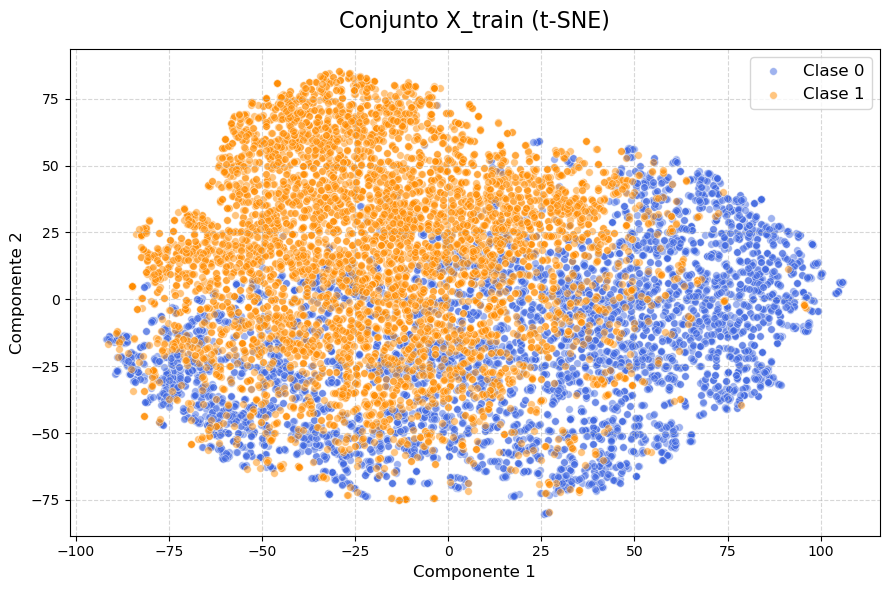

In [21]:
# Visualizar el conjunto original utilizando un scatter plot
plt.figure(figsize=(9, 6))
colores = ['royalblue', 'darkorange']  # Colores para las clases

for i, clase in enumerate([0, 1]):
    indices = Y_train == clase
    plt.scatter(
        X_train_2D[indices, 0], 
        X_train_2D[indices, 1], 
        label=f'Clase {clase}',
        alpha=0.5,  # Transparencia para observar superposición
        c=colores[i],
        edgecolor='w',  # Borde blanco para mayor claridad
        linewidth=0.5,
        s=30  # Tamaño de los puntos
    )

# Configuración del gráfico
plt.title("Conjunto X_train (t-SNE)", fontsize=16, pad=15)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar una cuadrícula suave
plt.tight_layout()
plt.show()


### Espacio latente

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Crear un modelo intermedio que llegue hasta la capa Flatten
modelo_intermedio = Model(
    inputs=modelo_completo.input,
    outputs=modelo_completo.layers[-2].output  # Salida de la capa Flatten
)

# Generar las predicciones del espacio latente para el conjunto de datos (X_train)
espacio_latente = modelo_intermedio.predict(X_train)

# Imprimir el número de observaciones y características
print(f"Dimensiones de X_train: {X_train_flat.shape}")
print(f"Dimensiones del espacio latente X_train: {espacio_latente.shape}")

388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Dimensiones de X_train: (12408, 606)
Dimensiones del espacio latente X_train: (12408, 42)


In [23]:

# Aplicar t-SNE para reducir las dimensiones del espacio latente a 2D
tsne_latente = TSNE(n_components=2, random_state=42)
espacio_latente_2D = tsne_latente.fit_transform(espacio_latente)

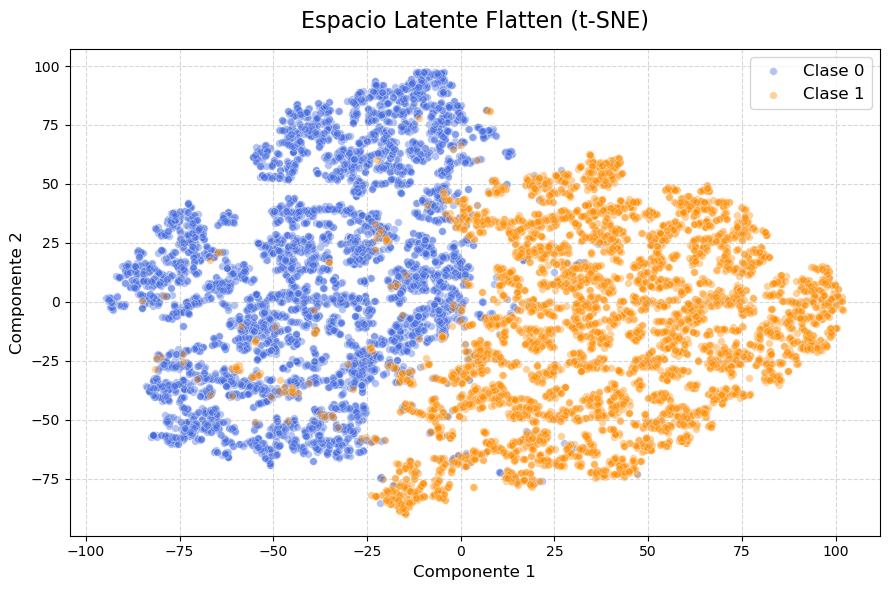

In [24]:
# Visualizar el espacio latente utilizando un scatter plot con mejoras
plt.figure(figsize=(9, 6))
colores = ['royalblue', 'darkorange']  # Colores para las clases

for i, clase in enumerate([0, 1]):
    indices = Y_train == clase
    plt.scatter(
        espacio_latente_2D[indices, 0], 
        espacio_latente_2D[indices, 1], 
        label=f'Clase {clase}',
        alpha=0.4,  # Transparencia para observar superposición
        c=colores[i],
        edgecolor='w',  # Borde blanco para mayor claridad
        linewidth=0.5,
        s=30  # Tamaño de los puntos
    )

# Configuración del gráfico
plt.title("Espacio Latente Flatten (t-SNE)", fontsize=16, pad=15)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar una cuadrícula suave
plt.tight_layout()
plt.show()